In [139]:
import pandas as pd
import numpy as np
import scipy.stats as st

import plotly.express as px

import matplotlib.pyplot as plt

from datetime import timedelta

from dateutil.relativedelta import relativedelta

import seaborn as sns

from tqdm import tqdm

### План презентации

1. Общая выкладка:
    1. Динамика revenue по продуктам
    2. Динамика по Регионам/Каналам
    

2. Разбор каждого показателя по продуктам
    1. Retention по продукту 
    2. Средний чек по продукту
    3. Средний жизненный цикл
    4. Как перетекает клиент из одного продукта в другой
    

3. Анализ ЦА
    1. Портрет покупателя 


### Предпроцессинг

На первом этапе обработаем данные для дальнейшей работы с ними

In [140]:
## Таблица с активностью клиентов

service = pd.read_csv('service_subs.csv')
service.head()

,time_key_dt,client_id_serv,segment,region_name,registration_month,channel,social_segment,revenue
0,2022-04-01,056420510833833900RN90,New - few observ,South,2022-03-01,Alternative,Ordinary,1611.0
1,2022-07-01,056420510833833900RN90,Stable,South,2022-03-01,Alternative,Ordinary,1733.0
2,2022-08-01,056420510833833900RN90,Stable,South,2022-03-01,Alternative,VIP,2227.0
3,2021-02-01,383020650785151030RN90,New - few observ,South,2021-02-01,Franchise,Family,437.0
4,2021-04-01,383020650785151030RN90,New - few observ,South,2021-02-01,Franchise,Family,442.0


In [141]:
## Таблица с пользователями комбо

combo = pd.read_csv('combo_ind.csv')
combo.head()

,time_key_dt,client_id_serv,combo_ind
0,2022-04-01,056420510833833900RN90,1
1,2022-07-01,056420510833833900RN90,1
2,2022-08-01,056420510833833900RN90,1
3,2021-01-01,683746213765168438RN96,1
4,2021-02-01,683746213765168438RN96,1


In [142]:
## Посмотрим на размеры таблиц

print(service.shape,combo.shape)

(12799809, 8) (305256, 3)


In [143]:
## Проверим типы даннных

print(service.dtypes, '\n')
print(combo.dtypes)

time_key_dt            object
client_id_serv         object
segment                object
region_name            object
registration_month     object
channel                object
social_segment         object
revenue               float64
dtype: object 

time_key_dt       object
client_id_serv    object
combo_ind          int64
dtype: object


In [144]:
## Скорректируем типо данных для колонок со временем

service['time_key_dt'] = pd.to_datetime(service.time_key_dt)
service['registration_month'] = pd.to_datetime(service.registration_month)
combo['time_key_dt'] = pd.to_datetime(combo.time_key_dt)

In [145]:
## Посмотрим на наличие пропущенных значений в таблице Service

print(service.isna().sum())

time_key_dt              0
client_id_serv          10
segment                  0
region_name              0
registration_month       0
channel                  0
social_segment           0
revenue               1218
dtype: int64


In [146]:
## У нас есть пустые строки id, их удалим. 
## Cтроки с пустым доходом также удалим, так как нам необходимы только активные пользователи

service.dropna(subset = ['client_id_serv', 'revenue'], inplace = True)

In [147]:
## Посмотрим на пропущенные значения в таблице combo

print(combo.isna().sum())

# Их нет

time_key_dt       0
client_id_serv    0
combo_ind         0
dtype: int64


In [148]:
## Для дальнейшего анализа нам понадобится сджойнить две таблицы

df = service.merge(combo, how = 'left', on = ['time_key_dt', 'client_id_serv'])
df.head()

,time_key_dt,client_id_serv,segment,region_name,registration_month,channel,social_segment,revenue,combo_ind
0,2022-04-01,056420510833833900RN90,New - few observ,South,2022-03-01,Alternative,Ordinary,1611.0,1.0
1,2022-07-01,056420510833833900RN90,Stable,South,2022-03-01,Alternative,Ordinary,1733.0,1.0
2,2022-08-01,056420510833833900RN90,Stable,South,2022-03-01,Alternative,VIP,2227.0,1.0
3,2021-02-01,383020650785151030RN90,New - few observ,South,2021-02-01,Franchise,Family,437.0,NaN
4,2021-04-01,383020650785151030RN90,New - few observ,South,2021-02-01,Franchise,Family,442.0,NaN


In [149]:
## Пользователей с подпиской "Connection service»" отметим как 0 и скорректируем нейминг в колонке

df.combo_ind.fillna(0, inplace = True)

In [150]:
df['combo_ind'] = df.combo_ind.apply(lambda x: 'Combo' if x == 1 else 'Connection Service')

In [151]:
## Посмотрим на статистики датафрейма на наличие ошибок 
df.describe()

,revenue
count,1.279859e+07
mean,1.564179e+03
std,1.595862e+03
min,-1.675790e+05
25%,3.720000e+02
50%,1.222000e+03
75%,2.259000e+03
max,1.877140e+05


In [152]:
## Мы видим что в колонке revenue, есть отрицательные значения. Допускаем, что это ошибочные данные, удалим их 

df = df.query('revenue > 0')

### Динамика revenue по продуктам

Проссумируем доход по месяцу и продукту 

In [153]:
revenue = df.groupby(['time_key_dt', 'combo_ind'], as_index = False)\
    .agg({'revenue': 'sum'}).sort_values(by = 'time_key_dt')
revenue.head()

,time_key_dt,combo_ind,revenue
0,2021-01-01,Combo,31182444.0
1,2021-01-01,Connection Service,883045014.0
2,2021-02-01,Combo,31995297.0
3,2021-02-01,Connection Service,817307876.0
4,2021-03-01,Combo,37611073.0


Добавим для аггрегированных данных колонку с динамикой роста revenue к прошлому периоду

In [154]:
revenue['last_rev'] = revenue.groupby('combo_ind')['revenue'].shift()
revenue['dynamic'] = (revenue['revenue'] / revenue['last_rev']) - 1
revenue.head()

,time_key_dt,combo_ind,revenue,last_rev,dynamic
0,2021-01-01,Combo,31182444.0,NaN,NaN
1,2021-01-01,Connection Service,883045014.0,NaN,NaN
2,2021-02-01,Combo,31995297.0,31182444.0,0.026068
3,2021-02-01,Connection Service,817307876.0,883045014.0,-0.074444
4,2021-03-01,Combo,37611073.0,31995297.0,0.175519


Построим график с динамикой revenue

/var/folders/6g/88x350f11_7g0g69mnxy58yh0000gn/T/ipykernel_19705/2970167926.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



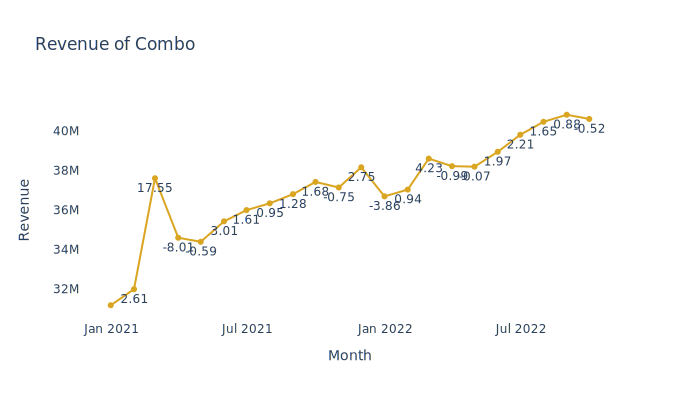

/var/folders/6g/88x350f11_7g0g69mnxy58yh0000gn/T/ipykernel_19705/2970167926.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



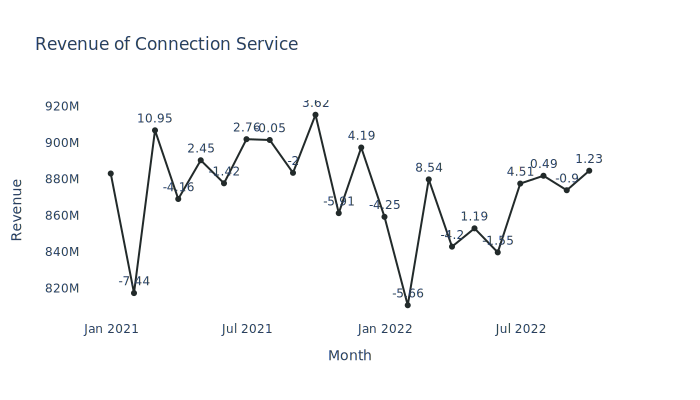

In [162]:
for i,c,p in zip(list(revenue.combo_ind.unique()),['goldenrod',"#222A2A"],["bottom center", "top center"]):

    data = revenue.query(f"combo_ind == '{i}'")
    data['dynamic'] = round((data['dynamic'] * 100),2)

    fig = px.line(data, x='time_key_dt', y='revenue',
                 color_discrete_sequence = [c], text= 'dynamic',
                 height=400, title=f"Revenue of {i}")
    
    fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                      plot_bgcolor = "rgba(0,0,0,0)",
                      xaxis_title="Month", 
                      yaxis_title="Revenue" )
    
    fig.update_traces(textposition=p)
    

    
    fig.show('svg')
    
    

Сравним абсолютный рост revenue год к году по октябрю у двух продуктов

In [156]:
mm = revenue['time_key_dt'].max()
m = mm - relativedelta(years=1)

data = revenue[(revenue['time_key_dt'].isin([m,mm]))]\
    .pivot(index = 'combo_ind', columns = 'time_key_dt', values = 'revenue' )

data.head()

data['total_uplift'] = round(((data[f'{data.columns[1]}']/  data[f'{data.columns[0]}']) - 1)*100,2)
data


time_key_dt,2021-10-01 00:00:00,2022-10-01 00:00:00,total_uplift
combo_ind,,,
Combo,37424134.0,40612950.0,8.52
Connection Service,915355263.0,884576550.0,-3.36


Посмотрим на ежемесячный рост revenue продуктов

In [157]:
round((revenue.groupby('combo_ind').agg({'dynamic':'mean'})*100),2)

,dynamic
combo_ind,
Combo,1.36
Connection Service,0.11


#### Вывод

1. Оба продукта имеют схожую сезонность, например в Январе и Апрель-Июне динамика отрицательная.
Отличие заключается лишь в том, что у Combo динамика более стабильная и имеет меньшие отклонения.
2. У продукта Сombo динамика более качественная, он в среднем растет 1.3%, когда как Connection Service почти не растет



### Динамика по Регионам

По каждому продукту просуммируем revenue по региону и месяцу

In [158]:
regions = df.groupby(['region_name', 'combo_ind', 'time_key_dt'], as_index = False).agg({'revenue': 'sum'})

Добавим долю региона от совокупного revenue 

In [159]:
total = regions.groupby(['combo_ind', 'time_key_dt'], as_index = False)\
    .agg({'revenue': 'sum'})\
    .rename(columns = {'revenue': 'total'})
            
regions = regions.merge(total, how = 'left', on = ['combo_ind', 'time_key_dt'])

regions['% total'] = round((regions['revenue'] / regions['total'])*100,2)

In [160]:
regions.head()

,region_name,combo_ind,time_key_dt,revenue,total,% total
0,Centre,Combo,2022-03-01,8275.0,38605927.0,0.02
1,Centre,Combo,2022-04-01,7033.0,38222555.0,0.02
2,Centre,Combo,2022-05-01,5126.0,38197267.0,0.01
3,Centre,Combo,2022-06-01,19571.0,38950394.0,0.05
4,Centre,Combo,2022-07-01,27279.0,39812407.0,0.07


Построим график с динамикой revenue по каждому региону

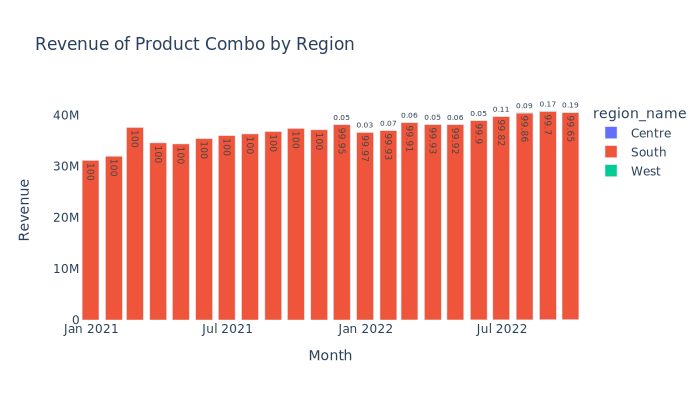

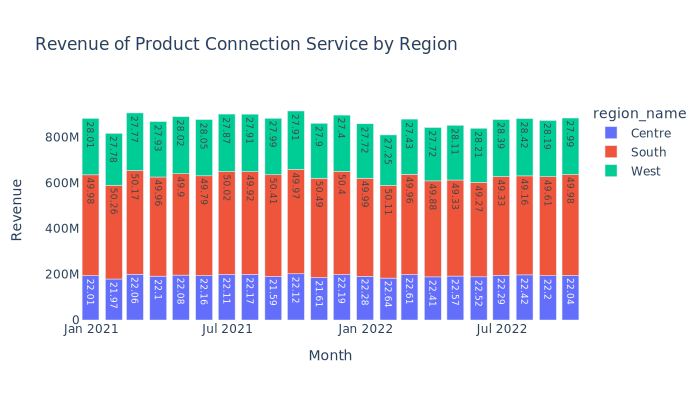

In [161]:
for i in list(regions.combo_ind.unique()):
    
    fig = px.bar(regions.query(f'combo_ind == "{i}"'), x='time_key_dt', y='revenue',
                 color='region_name', title=f"Revenue of Product {i} by Region", 
                 text= '% total', height=400)
    
    fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                      plot_bgcolor = "rgba(0,0,0,0)",
                      xaxis_title="Month", 
                      yaxis_title="Revenue" )
    
    fig.show("svg")

#### Вывод

1. Для Combo почти все продажи сосредоточены в регионе South, однако с конца 2021 года продажи начали появляться и в других регионах, но до сих пор их мизерное количество < 0.5%
2. Для Connection Service продажи распределены более пропорпционально, однако все равно большинство достается South( около 50%), остальное в поделено между West (~30%) и Centre(~20%)

### Динамика по каналам

По каждому продукту просуммируем revenue по каналу и месяцу и добавим долю канала от совокупных продаж продукта 

In [163]:
channel = df.groupby(['channel', 'combo_ind', 'time_key_dt'], as_index = False).agg({'revenue': 'sum'})

            
channel = channel.merge(total, how = 'left', on = ['combo_ind', 'time_key_dt'])

channel['% total'] = round((channel['revenue'] / channel['total'])*100,2)

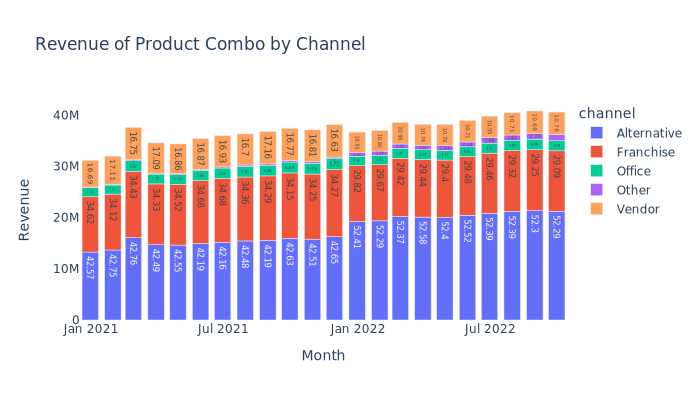

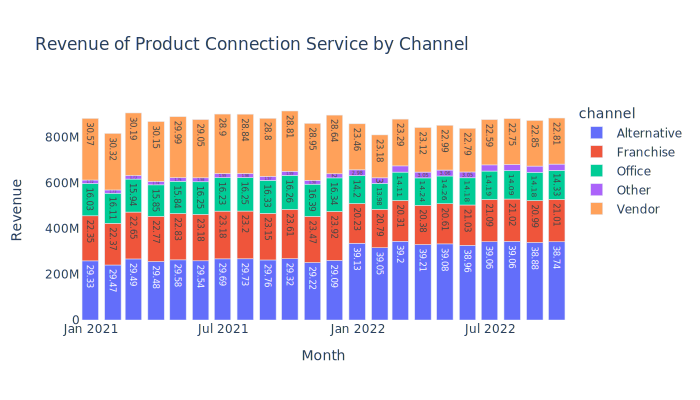

In [164]:
for i in list(channel.combo_ind.unique()):
    
    fig = px.bar(channel.query(f'combo_ind == "{i}"'), x='time_key_dt', y='revenue',
                 color='channel', title=f"Revenue of Product {i} by Channel", 
                 text= '% total', height=400)
    
    fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                      plot_bgcolor = "rgba(0,0,0,0)",
                      xaxis_title="Month", 
                      yaxis_title="Revenue" )
    
    fig.show("svg")

#### Вывод

1. Наибольшие доли для обоих продуктов занимают каналы Alternatiive, которые с января 2022 выросли примерно на 10 п.п за счет Vendor и Franchise
2. У Combo 80% приходится на Alternatiive и Franchise, а у Connection Service каналы более равномерно распределены 

### Разбор каждого показателя по продуктам

#### Retention

Для начала нам надо выбрать подход расчета Retention.
Поэтому изучим распределение дат регистраций

In [165]:
df['year_reg'] = df.registration_month.dt.year
round((df['year_reg'].value_counts(normalize = True)*100),2)

2021    9.56
2005    8.16
2020    8.02
2019    6.91
2006    6.41
2004    5.68
2016    5.54
2007    4.63
2018    4.62
2017    4.62
2011    4.51
2015    4.15
2010    3.99
2008    3.82
2009    3.79
2014    3.67
2012    3.41
2013    3.32
2022    2.90
2003    1.71
2002    0.50
2001    0.08
1970    0.00
1960    0.00
Name: year_reg, dtype: float64

Мы видим, что большинство дат регистраций находится вне дат нашего датафрейма.

Поэтому необходимо исключить пользователей, которые зарегестрировались раньше минимальной даты регистрации в нашем дата-фрейме, так как мы не знаем про их историю покупок.

И далее необходимо проанализировать, бывают ли случаи, когда пользователь зарегестрировавшись, в том же месяце не совершил покупки.


In [166]:
new_users = list(df[(df.registration_month >= df.time_key_dt.min() )].client_id_serv.unique())

new_users = df[(df.client_id_serv.isin(new_users))][['time_key_dt', 'registration_month', 'client_id_serv', 'revenue', 'combo_ind']]

new_users.groupby(['time_key_dt', 'registration_month'], as_index = False)\
    .agg({'client_id_serv': 'count'})\
    .query('registration_month == time_key_dt')\
    .rename(columns = {'client_id_serv': 'actions'})\
    .merge(new_users.groupby('registration_month', as_index = False)\
    .agg({'client_id_serv': 'nunique'}), how = 'left', on = 'registration_month')\
    .head()

,time_key_dt,registration_month,actions,client_id_serv
0,2021-01-01,2021-01-01,18926,20875
1,2021-02-01,2021-02-01,17782,19485
2,2021-03-01,2021-03-01,21957,23895
3,2021-04-01,2021-04-01,19410,21096
4,2021-05-01,2021-05-01,20708,22167


Мы видим, что регистрация != покупка, значит retention будем рассчитывать от первой покупки

In [167]:
first_purchase = new_users.groupby(['client_id_serv', 'combo_ind'], as_index = False)\
    .agg({'time_key_dt': 'min'})\
    .rename(columns = {'time_key_dt': 'first_purchase'})

new_users = new_users.merge(first_purchase, how = 'left', on = ['client_id_serv', 'combo_ind'])

new_users.head()

,time_key_dt,registration_month,client_id_serv,revenue,combo_ind,first_purchase
0,2022-04-01,2022-03-01,056420510833833900RN90,1611.0,Combo,2022-04-01
1,2022-07-01,2022-03-01,056420510833833900RN90,1733.0,Combo,2022-04-01
2,2022-08-01,2022-03-01,056420510833833900RN90,2227.0,Combo,2022-04-01
3,2021-02-01,2021-02-01,383020650785151030RN90,437.0,Connection Service,2021-02-01
4,2021-04-01,2021-02-01,383020650785151030RN90,442.0,Connection Service,2021-02-01


Посчитаем количество месяцев после первой покупки для каждого пользователя и его месяца активности

In [168]:
new_users['month_after_reg'] = new_users.time_key_dt.dt.to_period('M').view(dtype='int64') - new_users.first_purchase.dt.to_period('M').view(dtype='int64')+1
new_users.head()

,time_key_dt,registration_month,client_id_serv,revenue,combo_ind,first_purchase,month_after_reg
0,2022-04-01,2022-03-01,056420510833833900RN90,1611.0,Combo,2022-04-01,1
1,2022-07-01,2022-03-01,056420510833833900RN90,1733.0,Combo,2022-04-01,4
2,2022-08-01,2022-03-01,056420510833833900RN90,2227.0,Combo,2022-04-01,5
3,2021-02-01,2021-02-01,383020650785151030RN90,437.0,Connection Service,2021-02-01,1
4,2021-04-01,2021-02-01,383020650785151030RN90,442.0,Connection Service,2021-02-01,3


Считаем количество пользователей по первой покупки

In [169]:
reg = new_users.groupby(['first_purchase', 'combo_ind'], as_index = False)\
        .agg({'client_id_serv': 'nunique'}).rename(columns = {'client_id_serv': 'total_users_by_first_month'})
reg.head()

,first_purchase,combo_ind,total_users_by_first_month
0,2021-01-01,Combo,106
1,2021-01-01,Connection Service,18821
2,2021-02-01,Combo,133
3,2021-02-01,Connection Service,18791
4,2021-03-01,Combo,169


Джойним таблицу регистраций с таблицей регистрация + месяц покупки и считаем retention по каждому месяцу регистрации и месяцу покупки

In [170]:
retention = new_users.groupby(['first_purchase', 'month_after_reg', 'combo_ind'], as_index = False)\
    .agg({'client_id_serv': 'count'})\
    .merge(reg, how = 'left', on = ['first_purchase', 'combo_ind']).query('month_after_reg <= 12')


retention['retention'] = round((retention['client_id_serv'] / retention['total_users_by_first_month'])*100,2)

retention.head()

,first_purchase,month_after_reg,combo_ind,client_id_serv,total_users_by_first_month,retention
0,2021-01-01,1,Combo,106,106,100.00
1,2021-01-01,1,Connection Service,18821,18821,100.00
2,2021-01-01,2,Combo,97,106,91.51
3,2021-01-01,2,Connection Service,9606,18821,51.04
4,2021-01-01,3,Combo,97,106,91.51


Посмотрим на распределение retention, чтобы понять есть ли выбросы, которые покажут, какое среднее нам использовать

/Users/aleksandrkudravcev/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



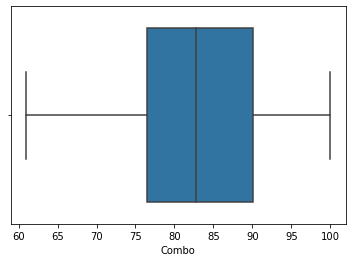

/Users/aleksandrkudravcev/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



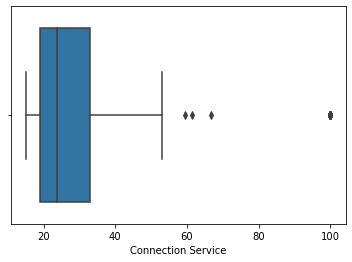

In [171]:
for i in list(retention.combo_ind.unique()):
    sns.boxplot(retention.query(f'combo_ind == "{i}"')['retention'])
    plt.xlabel(i)
    plt.show()

Мы видим, что на данных retention есть выбросы, поэтому для подсчета retention будем использовать отношение количества пользователей по каждому месяцу после даты первой покупки и всего количества зарегистрированных пользователей 

Проссумируем количество клиентов для каждого месяца после первой покупки и разделим на общее количество зарегистрировашихся клиентов

In [172]:
test = retention.groupby(['month_after_reg','combo_ind'], as_index = False)\
    .agg({'client_id_serv': 'sum', 'total_users_by_first_month':'sum'})

test['retention'] = round((test['client_id_serv'] / test['total_users_by_first_month'])*100,2)
test.pivot(index = 'combo_ind', columns = 'month_after_reg', values = 'retention')

month_after_reg,1,2,3,4,5,6,7,8,9,10,11,12
combo_ind,,,,,,,,,,,,
Combo,100.0,91.2,88.25,84.35,82.77,80.58,78.18,75.76,75.26,74.41,74.48,73.99
Connection Service,100.0,49.0,32.28,28.06,24.48,22.06,20.50,19.50,18.48,17.90,17.25,16.99


#### Вывод:

У Combo retention лучше для всех месяцев чем у тарифа Only Connection и на 12-й месяц превышает почти в 5 раз 

Построим график динамики Retention

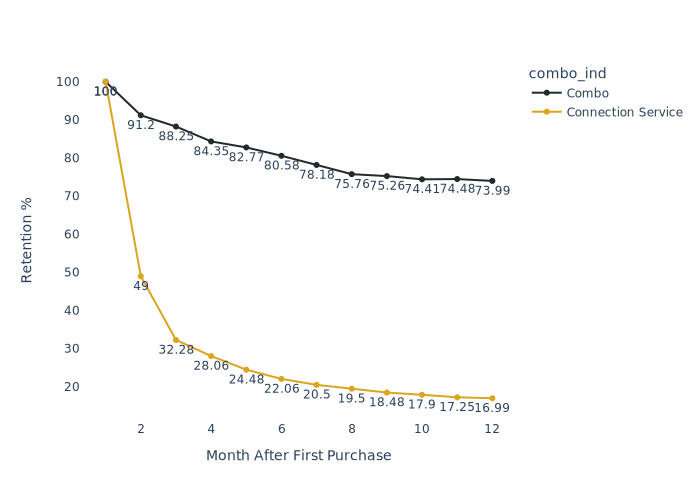

In [173]:
fig = px.line(test, x="month_after_reg", y="retention", 
              color='combo_ind', text = "retention", 
              color_discrete_sequence=["#222A2A", "goldenrod"])

fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)",
                  xaxis_title="Month After First Purchase", 
                  yaxis_title="Retention %")
    

fig.update_traces(textposition='bottom center')

fig.show("svg")

### lifetime 

Посмотрим, сколько в среднем месяцев проводит наш пользователь в продуктах в течение года.

Использовать будем данные про пользователей, которые совершили регистрацию после минимальной даты покупки в нашем дата-фрейме. 

То есть по тем пользователям, для которых мы рассчитывали retention

Дата первой покупки не должна быть меньше чем 12 месяцев до последней даты датафрейма, затем мы определяем количество покупок по пользователю внутри его годового цикла.

Потом мы возьмем только те месяцы активности, которые включены в 12 месяцев от регистрации.

так как мы рассчитываем среднюю длительность нахождения в продукте в течение всего года

In [174]:
new_users['max_date'] = new_users.time_key_dt.max()

new_users['total_circle'] = new_users['max_date'].dt.to_period('M').view(dtype='int64') - new_users.first_purchase.dt.to_period('M').view(dtype='int64')+1

life = new_users.query('total_circle >= 12')[['time_key_dt', 'registration_month', 'client_id_serv', 'revenue', 'combo_ind', 'first_purchase', 'total_circle']]

life = life[(life['time_key_dt'] < life['first_purchase'] + pd.DateOffset(months=12) ) ]
life.head()

,time_key_dt,registration_month,client_id_serv,revenue,combo_ind,first_purchase,total_circle
3,2021-02-01,2021-02-01,383020650785151030RN90,437.0,Connection Service,2021-02-01,21
4,2021-04-01,2021-02-01,383020650785151030RN90,442.0,Connection Service,2021-02-01,21
5,2021-05-01,2021-02-01,383020650785151030RN90,626.0,Connection Service,2021-02-01,21
6,2021-08-01,2021-02-01,383020650785151030RN90,545.0,Connection Service,2021-02-01,21
7,2021-10-01,2021-02-01,383020650785151030RN90,1189.0,Connection Service,2021-02-01,21


Посчитаем сумму месяцев активноси по каждому пользователю

In [175]:
life = life.groupby(['client_id_serv', 'combo_ind'], as_index = False).agg({'time_key_dt': 'nunique'})
life.head()

,client_id_serv,combo_ind,time_key_dt
0,000010587815856711IR90,Connection Service,4
1,000020587809601821IR90,Connection Service,5
2,000026113816461597ZN96,Connection Service,2
3,000030587811789829IR90,Connection Service,7
4,000036571781518232ZN96,Connection Service,1


Посмотрим на распределение количества месяцев в продукте, чтобы понять есть ли выбросы, которые покажут, какое среднее нам использовать

/Users/aleksandrkudravcev/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



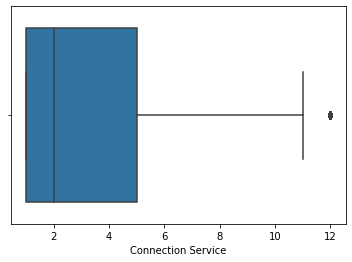

/Users/aleksandrkudravcev/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



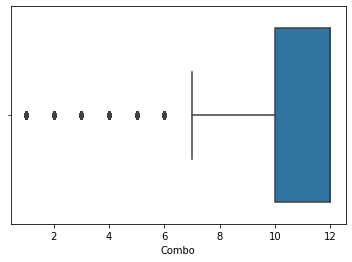

In [176]:
for i in list(life.combo_ind.unique()):
    sns.boxplot(life.query(f'combo_ind == "{i}"')['time_key_dt'])
    plt.xlabel(i)
    plt.show()

В распределении есть выбросы, поэтому для расчета среднего кол-ва месяцев будем рассчитывать по ЦПТ

In [177]:
lftm = []
for i in list(life.combo_ind.unique()):
    di = []    
    for j in tqdm(range(500)):
        x = life.query(f'combo_ind == "{i}"')['time_key_dt'].sample(1000)
        di.append(x.mean())
    lftm.append(round(sum(di)/len(di),2))
    print(i, round(sum(di)/len(di),2), 'months')
    

100%|█████████████████████████████████████████| 500/500 [00:10<00:00, 46.27it/s]


Connection Service 3.69 months


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 283.18it/s]

Combo 10.03 months


#### Вывод

Жизненный цикл клиента для Combo в два с половиной раза превосходит Connection Service и составляет в среднем 10 месяцев в год для новых пользователей

### Средний чек

Посмотрим на распределение среднего чека

/Users/aleksandrkudravcev/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



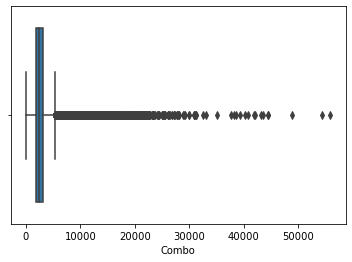

/Users/aleksandrkudravcev/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



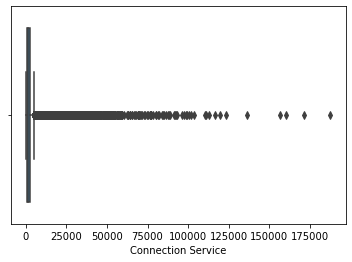

In [178]:
for i in list(df.combo_ind.unique()):
    sns.boxplot(df.query(f'combo_ind == "{i}"')['revenue'])
    plt.xlabel(i)
    plt.show()

Наблюдаем большое количество выбросов в распределении, поэтому посчитаем средний чек будем рассчитывать по ЦПТ

In [179]:
avg_rev = []
for i in list(df.combo_ind.unique()):
    di = []
    
    d = df.query(f'combo_ind == "{i}"')['revenue']
    
    for j in tqdm(range(500)):
        
        x = d.sample(500)
        di.append(x.mean())
    
    print(i, round(sum(di)/len(di),2))
    avg_rev.append(round(sum(di)/len(di),2))

100%|████████████████████████████████████████| 500/500 [00:02<00:00, 218.04it/s]


Combo 2686.28


100%|█████████████████████████████████████████| 500/500 [05:16<00:00,  1.58it/s]

Connection Service 1563.86


#### Вывод
Средний чек Сombo превосходит Сonnection service примерно в 1.7 раз 

### Рассчитаем годовой LTV продуктов

In [180]:
print('ltv_Combo = ', round(avg_rev[1]*lftm[0],2) )
print('ltv_CS = ', round(avg_rev[0]*lftm[1],2 ) )

ltv_Combo =  5770.64
ltv_CS =  26943.39


### Как перетекает пользователи из продукта в продукт 

Отфильтруем только тех пользователей, которые пользовались обоими продуктами и минимальную дату покупки продукта

In [181]:
migrations = df.groupby(['client_id_serv', 'combo_ind'], as_index = False)\
    .agg({'time_key_dt':'min'})\
    .pivot(index = 'client_id_serv', columns = 'combo_ind', values = 'time_key_dt' )\
    .dropna()\
    .reset_index()

migrations.head()

combo_ind,client_id_serv,Combo,Connection Service
0,000016056138846223RN96,2021-01-01,2022-06-01
1,000076056506513749RN96,2021-01-01,2021-10-01
2,000336796779560548ZN96,2022-07-01,2021-08-01
3,000576056741377123RN96,2021-01-01,2021-02-01
4,000886055744252768RN96,2021-04-01,2021-01-01


Отметим самую позднюю дату первой покупки и отметим, что это был за продукт и посчитаем долю переходов для каждого перехода

In [191]:
migrations['where_migrate'] = np.where(migrations['Combo'] > migrations['Connection Service'], 'Combo' , 'Connection Service')
round((migrations['where_migrate'].value_counts(normalize = True)*100),2).reset_index()

,index,where_migrate
0,Combo,68.41
1,Connection Service,31.59


В Combo мигрирует 68% всех меняющих продукт пользователей

Какой процент пользователей от всех пользователей combo перетекли из плана connection service?

In [192]:
round(migrations.query('where_migrate == "Combo"')['client_id_serv'].nunique() / df.query('combo_ind == "Combo"')['client_id_serv'].nunique()*100,2)

12.46

Какой процент пользователей от всех пользователей Connection service перетекли в Combo?

In [193]:
round(migrations.query('where_migrate == "Combo"')['client_id_serv'].nunique() / df.query('combo_ind == "Connection Service"')['client_id_serv'].nunique()*100,2)

0.21

#### Вывод

С точки зрения юнит-экономики Combo действительно лучше чем Connection Service

1. За счет пятикратного превосходства времени в продукте и на 70% большего среднего чека совокупнный доход от 1 клиента у Combo в 4,5 раза больше чем у Connection Service.
2. Также об этом свидельствует и то, что пользователи намного охотнее переходят с Connection Service на Combo, чем наоборот(в 2 раза)

### Портрет пользователя

#### Combo

Посмотрим на количество пользователей по сегментам и регионам

In [194]:
segments = df.query('combo_ind == "Combo"')\
    .groupby(['region_name','social_segment'], as_index = False)\
    .agg({'client_id_serv': 'nunique'})

segments['% of total users'] = round(segments['client_id_serv'] / segments.client_id_serv.sum()*100,2)

segments.sort_values(by = '% of total users', ascending = False)

,region_name,social_segment,client_id_serv,% of total users
5,South,Family,9414,42.43
6,South,Ordinary,7774,35.04
8,South,Student,1983,8.94
9,South,VIP,1804,8.13
7,South,Pensioner,984,4.44
10,South,Visitor,181,0.82
11,West,Family,13,0.06
0,Centre,Family,8,0.04
1,Centre,Ordinary,7,0.03
12,West,Ordinary,6,0.03


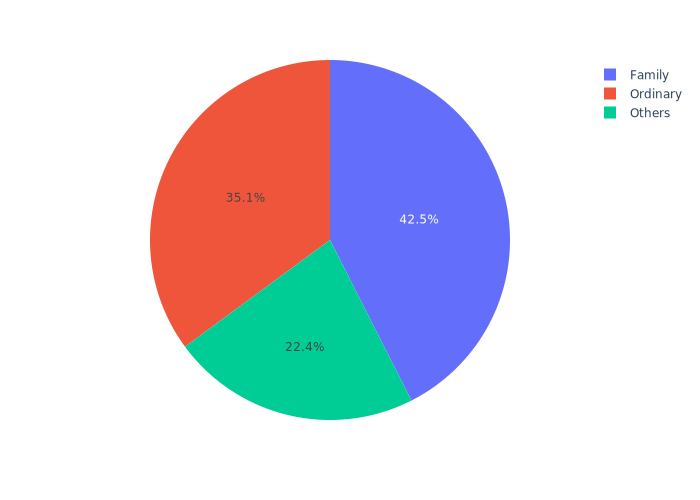

In [195]:
data = df.query('combo_ind == "Combo"')\
    .groupby(['social_segment'], as_index = False)\
    .agg({'client_id_serv': 'nunique'})

data['social_segment'] = data.social_segment.apply(lambda x: x if x in ['Family', 'Ordinary'] else 'Others')
data['% of total users'] = round(data['client_id_serv'] / data.client_id_serv.sum()*100,2)

fig = px.pie(data, values='% of total users', names='social_segment')

fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)")
fig.show('svg')

Большая часть пользователей это Family и Ordinary с South (~ 80%)

Теперь проанализируем, где они покупают

In [196]:
top_channel = df[(df['social_segment'].isin(['Family', 'Ordinary'])) & (df['combo_ind'] == 'Combo')]\
    .groupby(['channel'], as_index = False)\
    .agg({'client_id_serv': 'nunique'} ).sort_values(by = 'client_id_serv', ascending = False )

top_channel['%_of_total'] = round(top_channel.client_id_serv / top_channel.client_id_serv.sum()*100,2)

top_channel.rename(columns = {"client_id_serv": "users"})

,channel,users,%_of_total
0,Alternative,8470,49.46
1,Franchise,5155,30.10
4,Vendor,2182,12.74
2,Office,807,4.71
3,Other,510,2.98


In [197]:
top_channel['channel'] = top_channel.channel.apply(lambda x: x if x in ['Alternative', 'Franchise'] else 'Others')

In [198]:
top_channel

,channel,client_id_serv,%_of_total
0,Alternative,8470,49.46
1,Franchise,5155,30.10
4,Others,2182,12.74
2,Others,807,4.71
3,Others,510,2.98


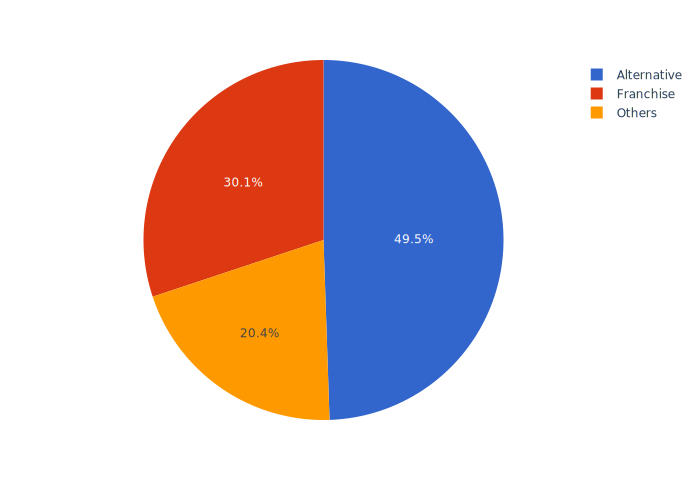

In [199]:
fig = px.pie(top_channel, values='%_of_total', names='channel', color_discrete_sequence = px.colors.qualitative.G10)

fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)")

fig.show('svg')

Большинство изучаемых нами покупателей пользуются каналами Alternative и Franchise

#### Вывод

Покупатель Combo - это сегменты в равной степени Family и Ordinary с South, которые покупают в Alternative и Franchise

#### Connection Service

In [200]:
segments = df.query('combo_ind == "Connection Service"')\
    .groupby(['region_name','social_segment'], as_index = False)\
    .agg({'client_id_serv': 'nunique'})

segments['% of total users'] = round(segments['client_id_serv'] / segments.client_id_serv.sum()*100,2)

In [201]:
segments.sort_values(by = ['% of total users'], ascending = False)

,region_name,social_segment,client_id_serv,% of total users
7,South,Ordinary,292300,25.23
1,Centre,Ordinary,163086,14.08
13,West,Ordinary,153211,13.22
17,West,Visitor,79380,6.85
8,South,Pensioner,74696,6.45
6,South,Family,55591,4.80
14,West,Pensioner,47405,4.09
9,South,Student,46493,4.01
11,South,Visitor,44686,3.86
2,Centre,Pensioner,44330,3.83


В текущей итерации не выделается других крупных сегментов, кроме Ordinary. 

Поэтому сгруппируем клиентов только по social_segment

In [202]:
segments = df.query('combo_ind == "Connection Service"')\
    .groupby(['social_segment'], as_index = False)\
    .agg({'client_id_serv': 'nunique'})

segments['% of total users'] = round(segments['client_id_serv'] / segments.client_id_serv.sum()*100,2)
segments.sort_values(by = '% of total users', ascending = False)

,social_segment,client_id_serv,% of total users
1,Ordinary,608597,52.53
2,Pensioner,166431,14.36
5,Visitor,147531,12.73
3,Student,93546,8.07
0,Family,93123,8.04
4,VIP,49395,4.26


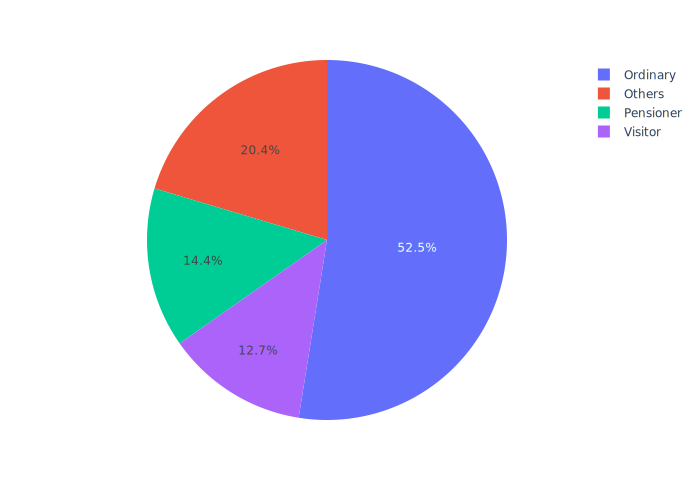

In [203]:
data = df.query('combo_ind == "Connection Service"')\
    .groupby(['social_segment', 'region_name'], as_index = False)\
    .agg({'client_id_serv': 'nunique'})

data['social_segment'] = data.social_segment.apply(lambda x: x if x in ['Pensioner', 'Ordinary','Visitor' ] else 'Others')
data['% of total users'] = round(data['client_id_serv'] / data.client_id_serv.sum()*100,2)

fig = px.pie(data, values='% of total users', names='social_segment')

fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)")
fig.show('svg')

Наиболее часто встречающийся сегмент это Ordinary, однако есть еще примерно 10-15% долей Pensioner и Visitor

Посмотрим по ним географическое распределение


In [204]:
segments = df[(df['combo_ind'] == "Connection Service")&(df['social_segment'].isin(['Ordinary', 'Pensioner', 'Visitor']))]\
    .groupby(['region_name'], as_index = False)\
    .agg({'client_id_serv': 'nunique'})

segments['% of total users'] = round(segments['client_id_serv'] / segments.client_id_serv.sum()*100,2)

In [205]:
segments

,region_name,client_id_serv,% of total users
0,Centre,226106,25.00
1,South,403134,44.57
2,West,275217,30.43


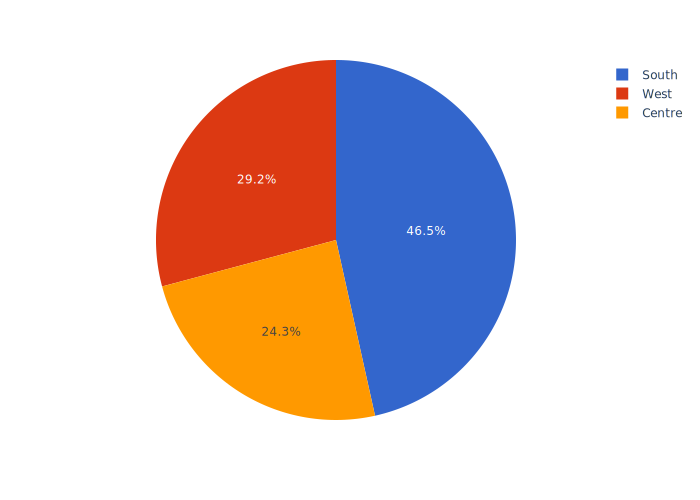

In [206]:
fig = px.pie(data, values='% of total users', names='region_name', color_discrete_sequence = px.colors.qualitative.G10)

fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)")
fig.show('svg')

Мы видим, что наибольшая часть пользователей c South(около 50%), но остальные регионы пропорциональны распределены.

Посмотрим, где покупает целевая аудитория 





In [207]:
channels = df[(df['combo_ind'] == "Connection Service")&(df['social_segment'].isin(['Ordinary', 'Pensioner', 'Visitor']))]\
    .groupby(['channel'], as_index = False)\
    .agg({'client_id_serv': 'nunique'})

channels['% of total users'] = round(channels['client_id_serv'] / channels.client_id_serv.sum()*100,2)

In [208]:
channels.sort_values(by = ['% of total users'], ascending = False)

,channel,client_id_serv,% of total users
0,Alternative,408698,41.92
1,Franchise,227733,23.36
4,Vendor,182620,18.73
2,Office,126923,13.02
3,Other,29001,2.97


In [210]:
channels['channel'] = channels.channel.apply(lambda x: x if x in ['Alternative', 'Franchise'] else 'Others')

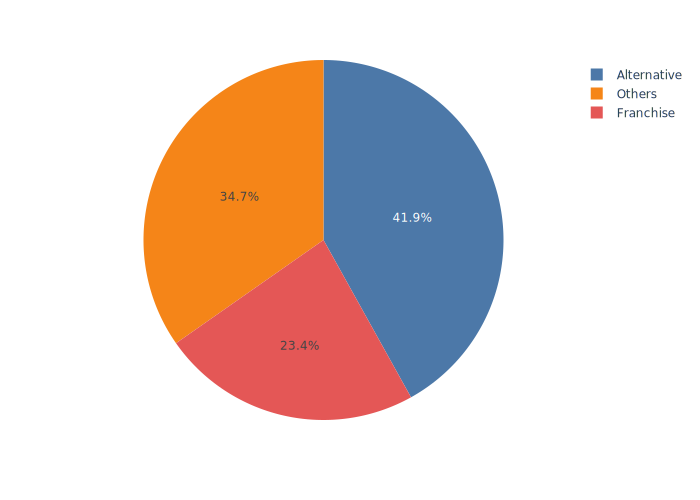

In [211]:
fig = px.pie(channels, values='% of total users', names='channel', color_discrete_sequence = px.colors.qualitative.T10)

fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)")

fig.show('svg')

Больших отличий от Combo нет

### Общие выводы:

1. Продукт Combo более обеспечивает ежемесячный стабильный рост и менее восприимчив к сезонным колебаниям за счет того, что его юнит-экономика превосходит экономику Connection Service почти в 5 раза. 

2. Более качественную экономику продукт Combo имеет из-за высокого Retention(за счет которого цикл клиента внутри года в среднем 10 месяцев) и среднего чека(на 70% выше)

3. Пользователи болеее охотно переходят в Combo. Из всех пользователей менявших продукт в Combo перешли ~ 70%

### Рекомендации
1. Продажи Combo происходят только в регионе South. Посколько продукт имеет отличную юнит-экономику необходимо активно заниматься его дистрибуцией и на других регионах.
2. Combo и Connection Service имеют большое пересечение в аудитории(Ordinary), поэтому рекомендовано переводить данный сегмент с Combo на Connection Service  

